<a href="https://colab.research.google.com/github/anamacam/machine_learning/blob/master/spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar librerias

In [1]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importar datos

In [39]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import spacy
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
spam = pd.read_csv('spam.csv', encoding='latin-1')
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
spam.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spam = spam.rename(columns={'v1':'target', 'v2':'text'})
spam.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Limpieza de texto

In [7]:
# Descargar las stopwords de nltk
nltk.download('stopwords')

# Definir las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para limpiar el texto
def clean_text(text):
    # Eliminar caracteres especiales, convertir a minúsculas y eliminar stopwords
    text = re.sub(r'\W', ' ', text)  # Eliminar caracteres especiales
    text = text.lower()  # Convertir a minúsculas
    text = text.split()  # Tokenización
    text = [word for word in text if word not in stop_words]  # Eliminar stopwords
    return ' '.join(text)

# Aplicar la función a la columna 'v2'
spam['cleaned_text'] = spam['text'].apply(lambda x: clean_text(str(x)))
print(spam['cleaned_text'].head()) # Print the head of the cleaned column

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                  u dun say early hor u c already say
4               nah think goes usf lives around though
Name: cleaned_text, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Tokenización

In [8]:
# Tokenización de la columna 'cleaned_v2'
spam['tokens'] = spam['cleaned_text'].apply(lambda x: word_tokenize(x))
print(spam['tokens'].head())

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
Name: tokens, dtype: object


Lematización

In [24]:
lemmatizer = WordNetLemmatizer()


spam['lemmatized'] = spam['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(spam['lemmatized'].head())

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, life, around, though]
Name: lemmatized, dtype: object


Análisis de Frecuencia de Palabras

In [10]:
!pip install wordcloud
from wordcloud import WordCloud

In [23]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

spam['lemmatized'] = spam['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(spam['lemmatized'].head())

all_words = [word for sublist in spam['lemmatized'] for word in sublist]
print(spam.columns)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, life, around, though]
Name: lemmatized, dtype: object
Index(['target', 'text', 'cleaned_text', 'tokens', 'lemmatized'], dtype='object')


TF-IDF (Term Frequency - Inverse Document Frequency)

In [22]:
spam_clean = pd.DataFrame({'cleaned_text': ['this is a test', 'another test document']})

# Crear el vectorizador TF-IDF
tfispam = TfidfVectorizer(max_features=100)

# Transformar el texto en una matriz TF-IDF utilizando la columna correcta
tfispam_matrix = tfispam.fit_transform(spam_clean['cleaned_text'])

# Ver los términos (palabras) y la matriz TF-IDF
print(tfispam.get_feature_names_out())  # Obtiene los nombres de las características

# Convertir la matriz TF-IDF a una matriz densa y mostrarla
print(tfispam_matrix.toarray())  # Muestra la matriz TF-IDF como un arreglo

['another' 'document' 'is' 'test' 'this']
[[0.         0.         0.6316672  0.44943642 0.6316672 ]
 [0.6316672  0.6316672  0.         0.44943642 0.        ]]


Modelo de regresión

In [31]:
# Importar las bibliotecas necesarias
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [33]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    spam['cleaned_text'], spam['target'], test_size=0.2, random_state=42
)

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Crear y ajustar el modelo de Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones
y_pred = model.predict(X_test_tfidf)

# Evaluar el modelo
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       1.00      0.86      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 0.9811659192825112


**Conclusión**

El modelo de clasificación muestra un desempeño excelente, con una alta precisión, recall y F1-score en general. La exactitud del 98.12% indica que el modelo es muy efectivo en distinguir entre "ham" y "spam". Sin embargo, el recall ligeramente más bajo para la clase "spam" sugiere que hay margen de mejora para identificar todos los ejemplos de spam correctamente. A pesar de esto, el modelo tiene una capacidad de discriminación muy alta y es confiable para la tarea de clasificación binaria.

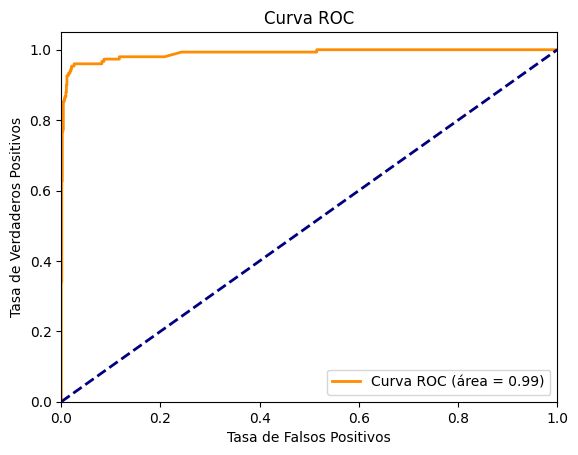

In [40]:
# Obtener las probabilidades de predicción para la clase positiva (spam)
y_probs = model.predict_proba(X_test_tfidf)[:, 1]

# Reemplazar 'spam' y 'ham' por 1 y 0 en y_test
y_test_numeric = y_test.map({'spam': 1, 'ham': 0})

# Calcular la curva ROC usando y_test_numeric
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

La gráfica muestra que el modelo tiene una capacidad de discriminación muy alta entre las clases positivas y negativas, ya que la curva ROC está muy cerca del punto superior izquierdo y el AUC es 0.99. Esto sugiere que el modelo es muy eficaz en la clasificación binaria para los datos evaluados.